In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) (1 − Pr(vampire))$$

In [2]:
pr_positive_vampire = 0.95
pr_positive_mortal= 0.01
pr_vampire = 0.001
pr_positive = pr_positive_vampire * pr_vampire + pr_positive_mortal * (1 - pr_vampire)
pr_vampire_positive = pr_positive_vampire * pr_vampire / pr_positive
pr_vampire_positive

0.08683729433272395

#### Code 3.2: Grid approximate posterior

We are going to use the same function we use on chapter 2 (code 2.3)

In [3]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior=None):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior is None:
        prior = np.repeat(5, grid_points)  # uniform
    elif prior == 'step':
        prior = (p_grid >= 0.5).astype(int)  # truncated
    elif prior == 'peaked':
        prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### 3.3: Sample from a posterior

In [4]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### 3.4 - 3.5: Plotting the samples & density estimate

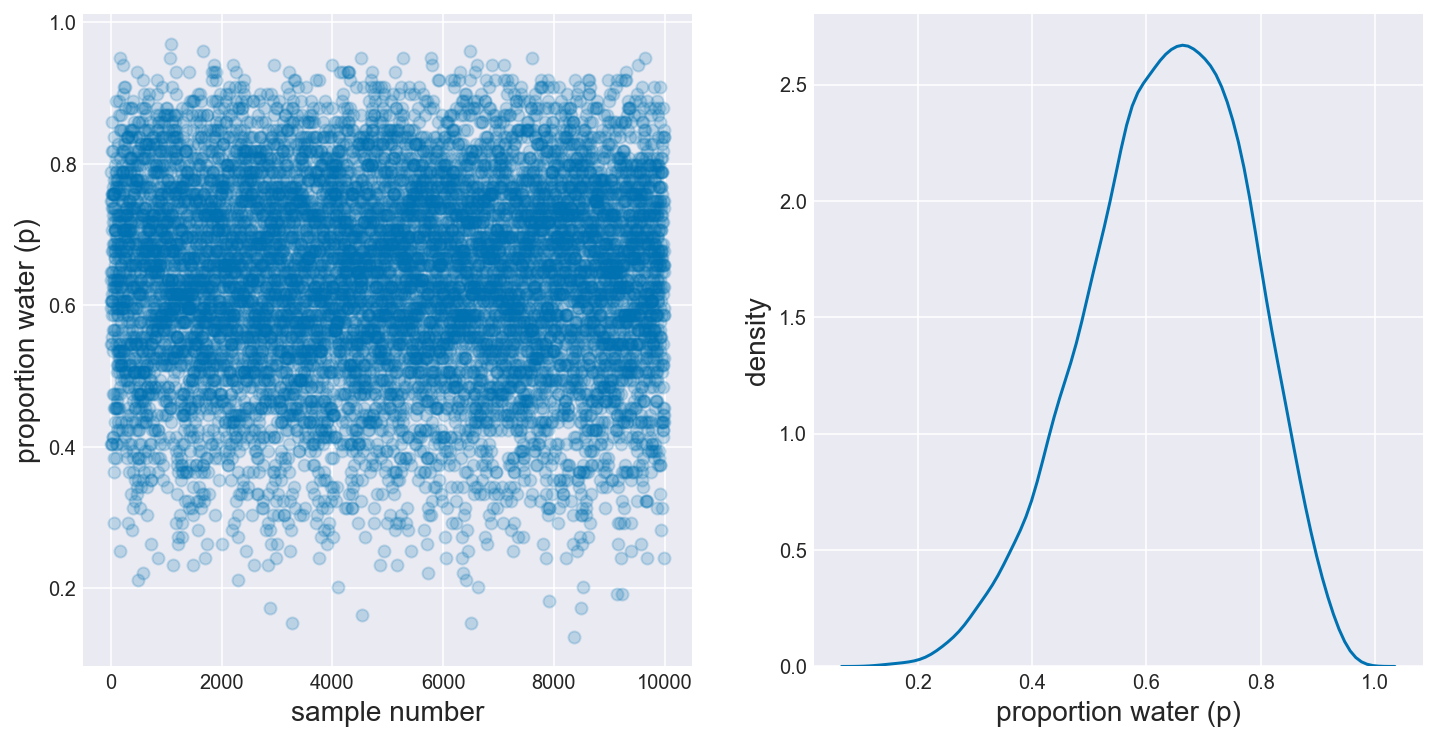

In [5]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
sns.kdeplot(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

#### Code 3.6: Calculate the posterior probability that the proportion of water < 0.5 using grid approximation

In [6]:
sum(posterior[ p_grid < 0.5 ])

0.17183313110747478

#### Code 3.7: Calculate the posterior probability that the proportion of water < 0.5 using samples

In [7]:
sum( samples < 0.5 ) / 1e4

0.1707

#### Code 3.8: How much posterior probability lies between 0.5 and 0.75

In [8]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6128

#### Code 3.9: 80th percentile

In [9]:
np.percentile(samples, 80)

0.7575757575757577

#### Code 3.10: Middle 80% interval

In [23]:
def percentile_interval(samples, prob):
    """
    Analogous to the PI() function referenced in 3.12.
    Given a list of samples and a probability, finds the bounds
    of the central probability
    
    Assumes prob is between 0 and 1
    """
    min_val = (1-prob)/2
    max_val = prob + min_val
    bounds = np.percentile(samples, [min_val * 100, max_val * 100])
    print(f'(min bound) {min_val:.2f}: {bounds[0]:.3f}')
    print(f'(max bound) {max_val:.2f}: {bounds[1]:.3f}')
    return bounds
    

In [24]:
percentile_interval(samples, 0.8)

(min bound) 0.10: 0.444
(max bound) 0.90: 0.808


array([0.44444444, 0.80808081])

In [25]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.80808081])

#### Code 3.11: Grid-aproximation of 3 waters in 3 tosses

In [30]:
# This is the plotting function from chapter 2 with labels changed
def plot_posterior(points, success, tosses, prior=None, interval_bounds=None):
    
    fig, ax = plt.subplots()
    
    p_grid, posterior = posterior_grid_approx(points, success, tosses, prior=prior)
    ax.plot(p_grid, posterior, label='success = {}\ntosses = {}'.format(success, tosses))
    plt.xlabel('Proportion of Water (p)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title('{} points'.format(points))
    plt.legend(loc=0);
    
    
    # Make the shaded region if we have interval_bounds
    if interval_bounds is not None:
        min_bound = interval_bounds[0]
        max_bound = interval_bounds[1]
        mask = ((p_grid >= min_bound) & (p_grid <= max_bound))
        ix = p_grid[mask]
        iy = posterior[mask]
        verts = [(min_bound, 0), *zip(ix, iy), (max_bound, 0)]
        poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
        ax.add_patch(poly)

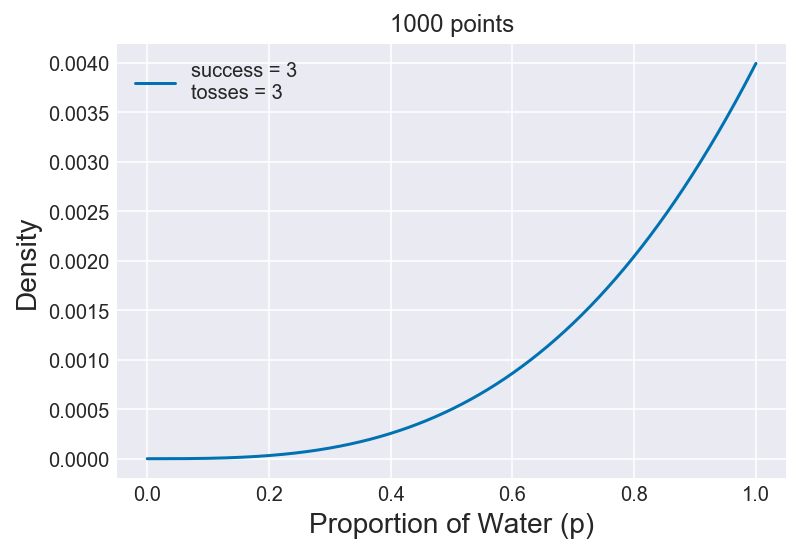

In [31]:
plot_posterior(points=1000, success=3, tosses=3)

#### Code 3.12: 50% percentile confidence interval of above graph

(min bound) 0.25: 0.704
(max bound) 0.75: 0.931


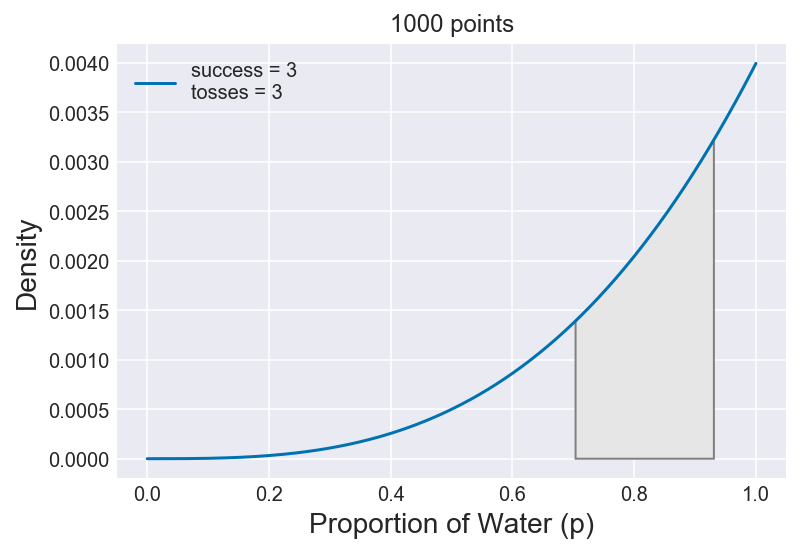

In [32]:
p_grid, posterior = posterior_grid_approx(grid_points=1000, success=3, tosses=3)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
interval_bounds = percentile_interval(samples, 0.5)

# Plotting this interval as well
plot_posterior(points=1000, success=3, tosses=3, interval_bounds=interval_bounds)

#### Code 3.13: Highest Posterior Density Interval (HPDI)

[0.83983984 1.        ]


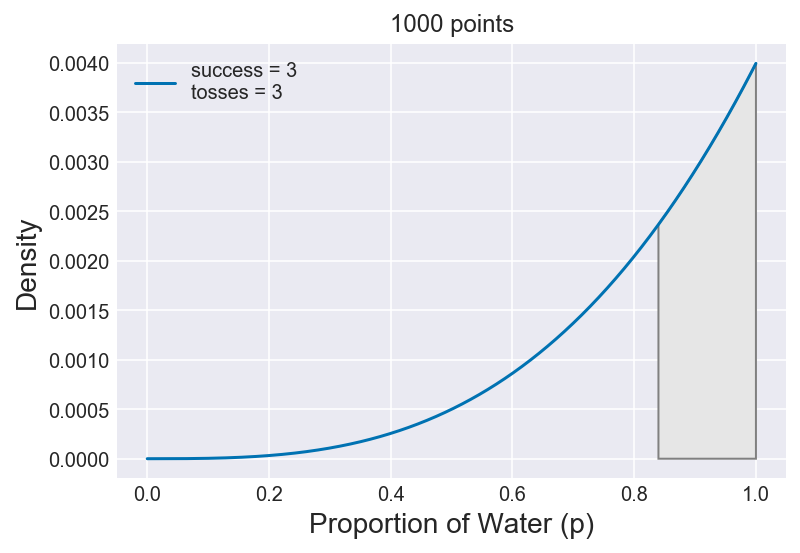

In [34]:
interval = pm.hpd(samples, alpha=0.5)
print(interval)

# Plotting this interval as well
plot_posterior(points=1000, success=3, tosses=3, interval_bounds=interval)

#### Code 3.14: Maximum a posteriori (MAP) estimate

In [35]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15: MAP estimate from samples (aka mode)

In [36]:
stats.mode(samples)[0]

array([0.99299299])

#### Code 3.16: posterior mean & median

In [37]:
np.mean(samples), np.median(samples)

(0.798662062062062, 0.8398398398398398)

#### Code 3.17: Calculating loss if our decision is 0.5

In [38]:
decision = 0.5
sum(posterior * abs(decision - p_grid))

0.3128751874998122

#### Code 3.18: Calculate loss for every possible decision (every value in p_grid)

In [39]:
loss = [sum(posterior * abs(decision - p_grid)) for decision in p_grid]

#### Code 3.19: Choose the minimum loss (and its corresponding decision value)

In [40]:
p_grid[loss == min(loss)]

array([0.84084084])

#### Code 3.20

In [41]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [50]:
tosses = 2
num_samples = 1
results = stats.binom.rvs(n=tosses, p=0.7, size=num_samples)
print(f'Num waters in {tosses} tosses: {results}')

Num waters in 2 tosses: [1]


#### Code 3.22

In [85]:
tosses = 2
num_samples = 10
results = stats.binom.rvs(n=tosses, p=0.7, size=num_samples)
print(f'Num waters in {tosses} tosses: {results}')

Num waters in 2 tosses: [1 2 2 2 0 2 2 2 2 2]


#### Code 3.23: Verify 0, 1, and 2 appear in proportion to their likelihoods

In [87]:
expected_likelihoods = stats.binom.pmf(range(3), n=2, p=0.7)

dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
sampled_likelihoods = [(dummy_w == i).mean() for i in range(3)]

print(f'Expected likelihoods: {expected_likelihoods}')
print(f'Sampled likelihoods: {sampled_likelihoods}')

Expected likelihoods: [0.09 0.42 0.49]
Sampled likelihoods: [0.08976, 0.42013, 0.49011]


#### Code 3.24: Histogram when p = 0.7

In [92]:
def plot_histogram(tosses, prob, samples=10000):
    """
    Analogous to simplehist referenced in 3.24.
    Samples a binomial defined by the input parameters
    and plots the outputs as a histogram
    """
    dummy_w = stats.binom.rvs(n=tosses, p=prob, size=samples)
    bins = np.linspace(-1,tosses,tosses+2) + 0.5
    plt.hist(dummy_w, bins=bins, width=0.5)
    plt.xlabel(f'dummy water count in {tosses} tosses', fontsize=14)
    plt.xticks(np.arange(0,tosses+1))
    plt.ylabel('Frequency', fontsize=14);

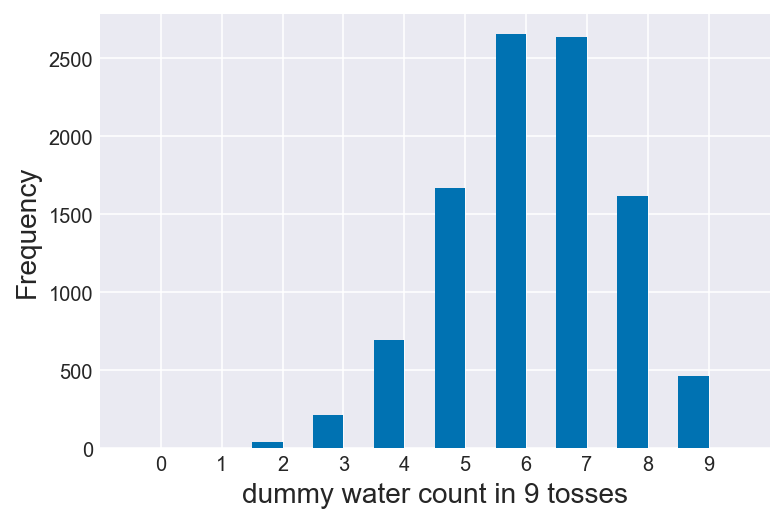

In [93]:
plot_histogram(tosses=9, prob=0.7)

#### Code 3.25: Histogram when p = 0.6

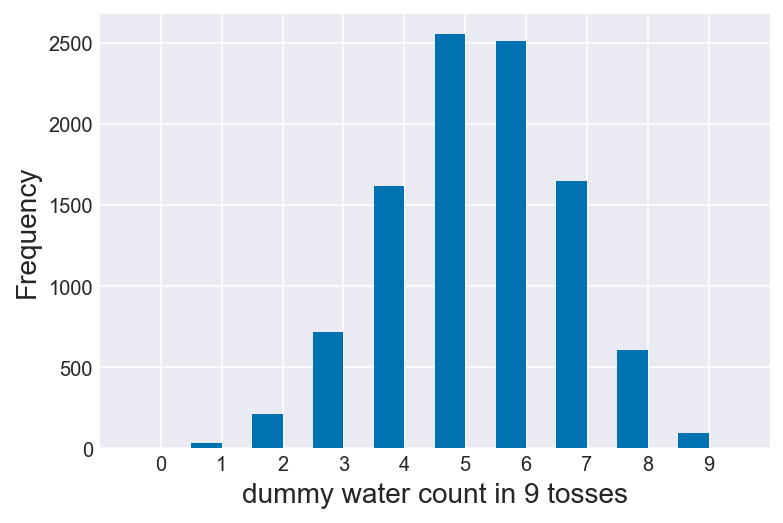

In [96]:
plot_histogram(tosses=9, prob=0.6)

#### Code 3.26: Histogram factoring in the full posterior distribution of p

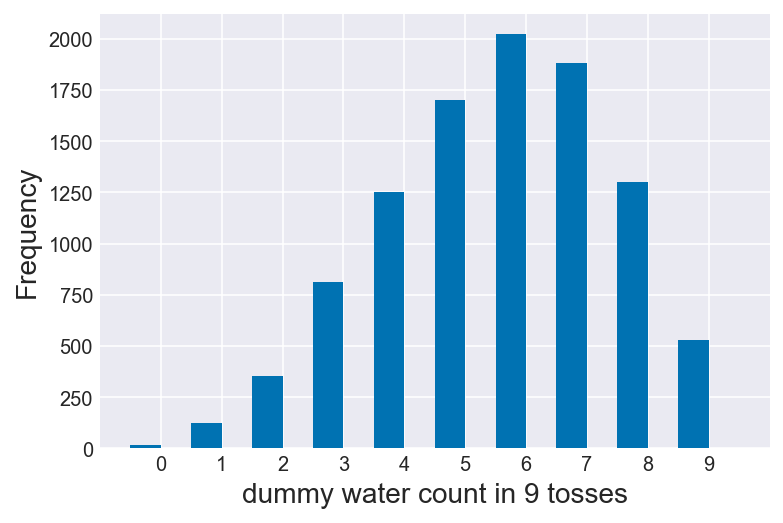

In [102]:
# Generate samples from the posterior when there are 6 waters in 9 tosses
success = 6
tosses = 9
p_grid, posterior = posterior_grid_approx(grid_points=1000, success=success, tosses=tosses)
prob_samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

# Plot the histogram, feeding in samples instead of probabilities
# Need to force the num of samples for the histogram to be the same as
# the number of prob_samples
plot_histogram(tosses=9, prob=prob_samples, samples=len(prob_samples))

#### Code 3.27: Setup for book problems

In [104]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

### Book Problems

#### 3E1: How much posterior probability lies below p=0.2?

#### 3E2: How much posterior probability lies above p=0.8?

#### 3E3: How much posterior probability lies between p=0.2 and p=0.8?

#### 3E4: 20% of the posterior probability lies below which value of p?

#### 3E5: 20% of the posterior probability lies above which value of p?

#### 3E6: Which values of p contain the narrowest interval equal to 66% of the posterior probability?

#### 3E7: Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

#### 3M1: Suppose the glove tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

#### 3M2: Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.

#### 3M3: Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?

#### 3M4: Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

#### 3M5: Start over at 3M1, but now use a prior that is zero below p=0.5 and a constant above p=0.5. This corresponds to prior information that a majority of the Earth's surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value p=0.7.

In [ ]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [ ]:
sum(birth1) + sum(birth2)

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))